Based on paper: https://d-nb.info/1248317343/34

# Importing Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data_folder = 'Data'
filename = 'Clean_data.csv'
file_path = os.path.join(data_folder, filename)

if not os.path.isfile(file_path):
    raise FileNotFoundError(f"The file '{file_path}' does not exist.")

# Read the CSV without parsing dates
merged_df = pd.read_csv(file_path)

# Creating Environment Specific df

In [3]:
Env_df = merged_df[['Inflation_Rate (%)','Avg_Interest_Rate','Output_gap (%)']]
Env_df

,Inflation_Rate (%),Avg_Interest_Rate,Output_gap (%)
0,0.20,9.880,2.45
1,0.97,8.880,2.68
2,1.03,8.630,2.95
3,1.98,8.080,3.62
4,1.78,10.755,3.41
...,...,...,...
75,1.26,4.500,-0.09
76,0.76,4.750,-0.02
77,0.01,5.000,-0.07
78,0.17,5.250,0.33


# Importing ANN Models

In [4]:
from ANN import ANN_Model

ann_model_y = ANN_Model.load('ANN_Weights/y.pth',input_dim= 4, hidden_dim=3)
ann_model_pi = ANN_Model.load('ANN_Weights/pi.pth',input_dim= 6, hidden_dim=4)

Model loaded from ANN_Weights/y.pth
Model loaded from ANN_Weights/pi.pth


c:\Users\sebas\Desktop\LSE_2.0\MSc Statistics\ST449\ST449_Project\ANN.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


# Environment

In [5]:
from PaperEnv import PaperBasedEconomyEnv

env = PaperBasedEconomyEnv(
    historical_df=Env_df,
    model_y= ann_model_y,
    model_pi= ann_model_pi,
    lookback_periods=2,
    inflation_target=2.0,
    output_gap_target=0.0,
    max_steps=5  # Force each episode to be 50 steps
)

# Train

In [6]:
from stable_baselines3.common.monitor import Monitor
log_dir = "./logs/"
env = Monitor(env, filename=log_dir)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

venv = DummyVecEnv([lambda: env])  # wrap your environment

model = PPO(
    policy="MlpPolicy",
    env=venv,
    verbose=1,
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # You can tune many hyperparameters here
)
model.learn(total_timesteps=10_000)


Using cuda device


c:\Users\sebas\Desktop\LSE_2.0\MSc Statistics\ST449\ST449_Project\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -108     |
| time/              |          |
|    fps             | 306      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | -108         |
| time/                   |              |
|    fps                  | 218          |
|    iterations           | 2            |
|    time_elapsed         | 18           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0024851165 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.0114      |
|    learning_r

# Visualizing Results

In [10]:
monitor_df = pd.read_csv(log_dir+"monitor.csv", skiprows=1)  # Adjust 'skiprows' if necessary

# Display the first few rows to verify
print(monitor_df.head())

            r   l         t
0 -107.570451  50  0.429468
1 -106.657394  50  0.634072
2 -107.221471  50  0.794250
3 -107.203865  50  0.973290
4 -106.960998  50  1.150747


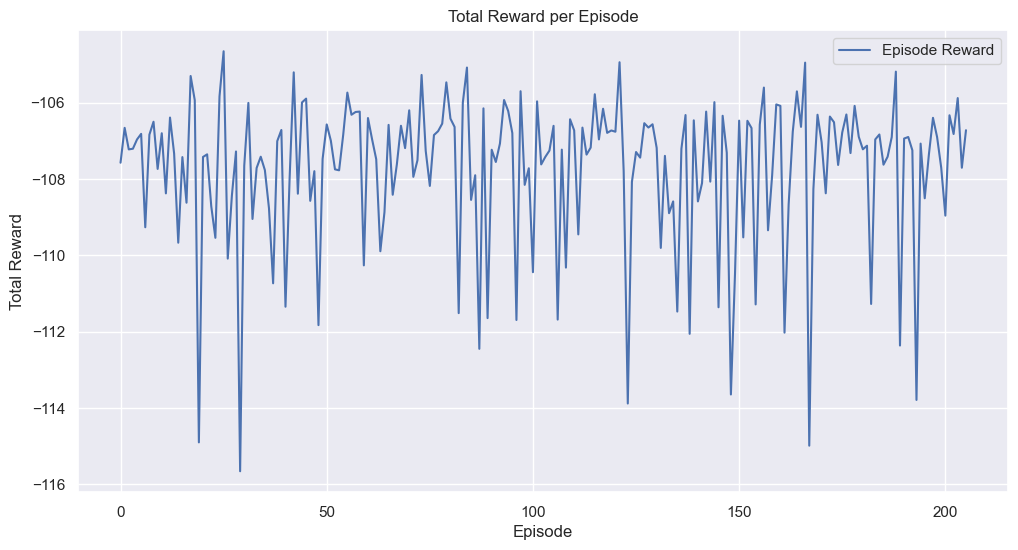

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for aesthetics
sns.set_theme(style="darkgrid")

# Plot total reward per episode
plt.figure(figsize=(12, 6))
plt.plot(monitor_df['r'], label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.show()


In [8]:
import matplotlib.pyplot as plt

# Reset the environment
obs = venv.reset()

# This list will hold (step, action, reward, observation)
step_log = []


for i in range(100):
    # Use the trained model to predict an action
    action, _ = model.predict(obs)
    # Take a step in the environment
    obs, rewards, dones, infos = venv.step(action)

    # For a single-environment VecEnv, obs has shape (1, obs_dim),
    # action has shape (1, action_dim), and rewards/dones are length-1 arrays.
    # We'll store the *first* environment's values

    # Convert to float to avoid arrays in the log
    step_idx = i
    act_value = float(action[0][0])  # if your action shape is (1, 1)
    reward_value = float(rewards[0])

    # obs[0] is the actual observation array for the first (and only) env
    # We'll store a copy so it doesn't get overwritten next iteration
    observation_array = obs[0].copy()

    step_log.append((step_idx, act_value, reward_value, observation_array))

    # If done, reset the environment
    if dones[0]:
        obs = venv.reset()




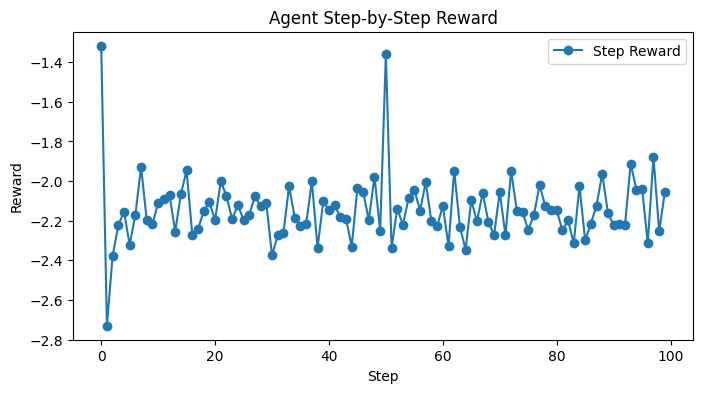

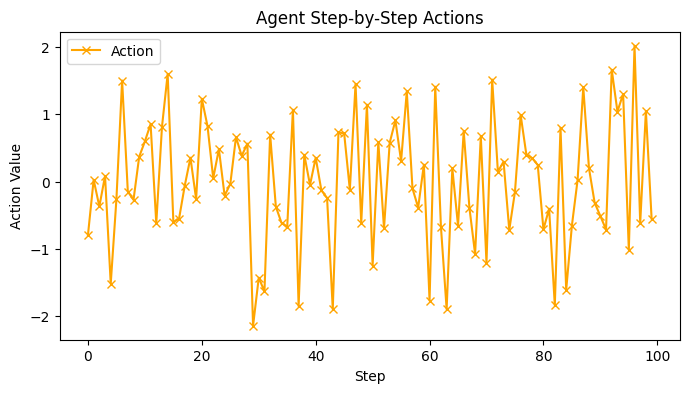

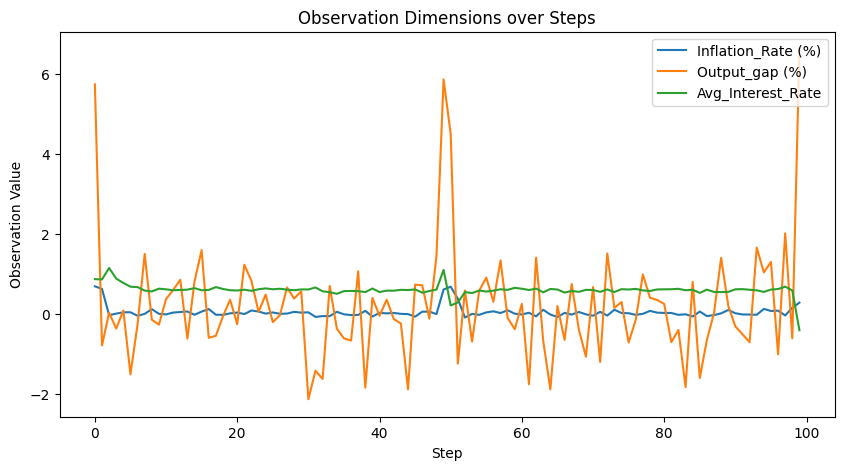

In [9]:
col_names = [
    'Inflation_Rate (%)',
    'Output_gap (%)',
    'Avg_Interest_Rate'
]

# -------------------------------------------------
# Convert the logged data into NumPy arrays for plotting
# -------------------------------------------------
steps = np.array([x[0] for x in step_log])
actions = np.array([x[1] for x in step_log])
step_rewards = np.array([x[2] for x in step_log])
observations = np.array([x[3] for x in step_log])  # shape: (num_steps, obs_dim)

# -------------------------------------------------
# 1) Plot the step-by-step rewards
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(steps, step_rewards, marker='o', label='Step Reward')
plt.title("Agent Step-by-Step Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.show()

# -------------------------------------------------
# 2) Plot the step-by-step actions
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(steps, actions, marker='x', color='orange', label='Action')
plt.title("Agent Step-by-Step Actions")
plt.xlabel("Step")
plt.ylabel("Action Value")
plt.legend()
plt.show()

# -------------------------------------------------
# 3) Plot the observations (each dimension separately)
# -------------------------------------------------
obs_dim = observations.shape[1]  # how many features per observation
plt.figure(figsize=(10, 5))
for dim in range(3):
    plt.plot(steps, observations[:, dim], label= col_names[dim])

plt.title("Observation Dimensions over Steps")
plt.xlabel("Step")
plt.ylabel("Observation Value")
plt.legend()
plt.show()